### Importing and loading the Cleaned Data File.

In [1]:
import pandas as pd
df_encoded = pd.read_pickle("churn_data_cleaned.pkl")
df_encoded.head(10)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
5,0,8,99.65,820.50,1,False,False,False,True,False,...,False,True,False,True,False,False,True,False,True,False
6,0,22,89.10,1949.40,0,True,False,True,True,False,...,False,True,False,False,False,False,True,True,False,False
7,0,10,29.75,301.90,0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
8,0,28,104.80,3046.05,1,False,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
9,0,62,56.15,3487.95,0,True,False,True,True,False,...,False,False,False,False,True,False,False,False,False,False


### Splitting the data into Training and Testing sets.

In [2]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Training a Naive Tree - (Not ideal).

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt_naive = DecisionTreeClassifier(random_state=42)
dt_naive.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [4]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, dt_naive.predict(X_train))
test_acc = accuracy_score(y_test, dt_naive.predict(X_test))

train_acc, test_acc

(0.9980475683351083, 0.7260468417317246)

#### There is a major variance between the Train and Test data. This is because Unconstrained Decision memorizes the training Data leading to this major variance.

### Looking beyond the Accuracy.

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_test, dt_naive.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1035
           1       0.48      0.48      0.48       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409



#### NOTE: If Recall is low, many Churners are missed.

### First Visualisation of the Tree...

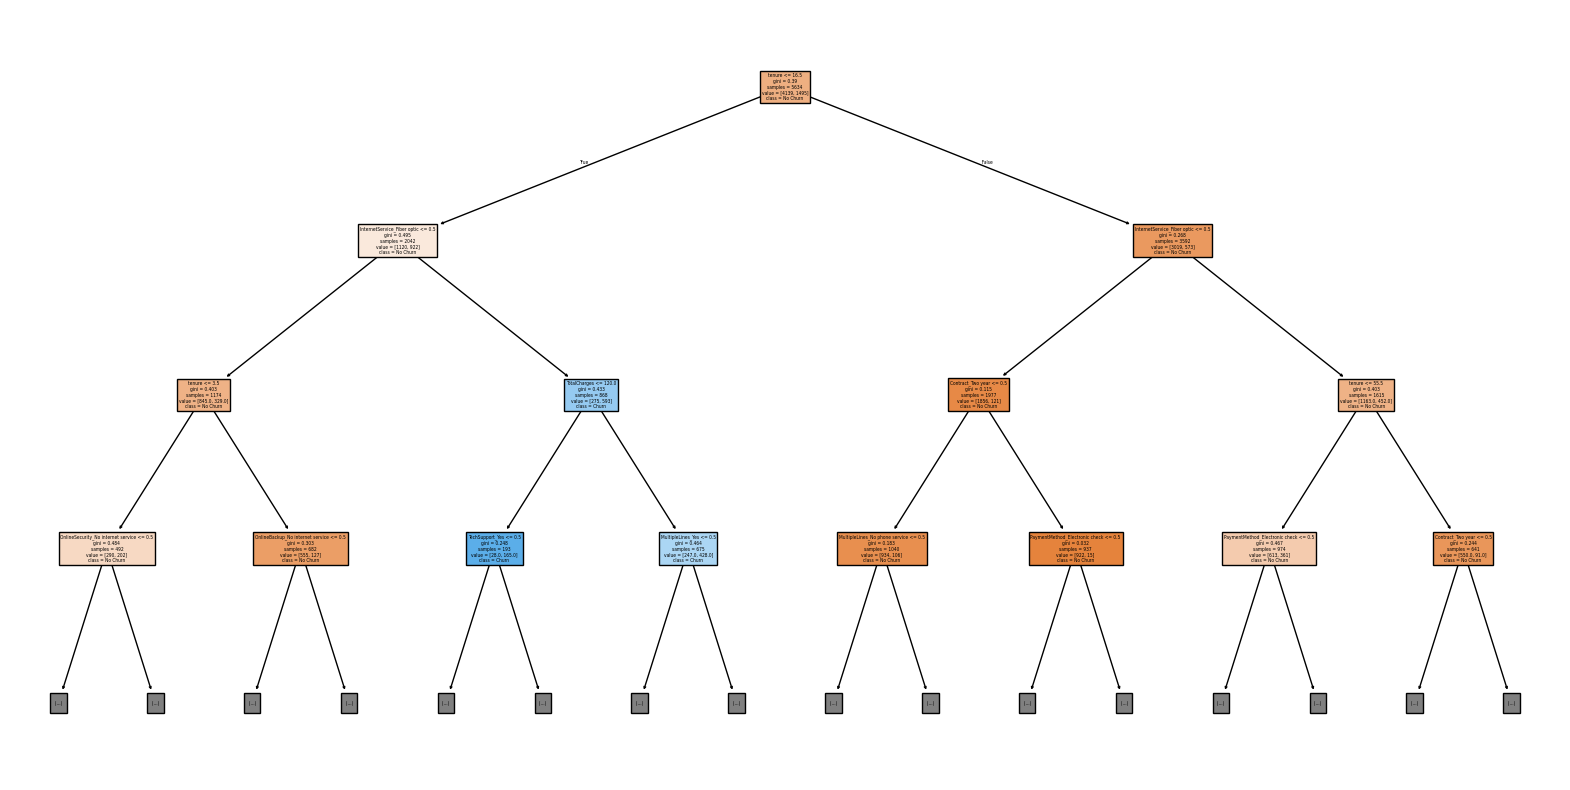

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt_naive,
    max_depth=3,
    feature_names=X.columns,
    class_names=['No Churn', 'Churn'],
    filled=True
)
plt.show();

### Now Training a Regularised Decision Tree.

In [7]:
dt_regularized = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=20,
    random_state=42
)

dt_regularized.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Evaluating the Training and Testing Datasets.

In [8]:
train_acc = accuracy_score(y_train, dt_regularized.predict(X_train))
test_acc = accuracy_score(y_test, dt_regularized.predict(X_test))

train_acc, test_acc

(0.8015619453319134, 0.7955997161107168)

#### The Training accuracy has reduced and the Testing Accuracy has increased.  Both values are now similar in values.

#### This gives the results a better generalisation.

### Checking the Classification Report

In [9]:
print(classification_report(
    y_test,
    dt_regularized.predict(X_test)
))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



### This model sacrifices some precision to improve recall, which is acceptable for churn prevention.

### Visualising the Controlled Decision Tree.

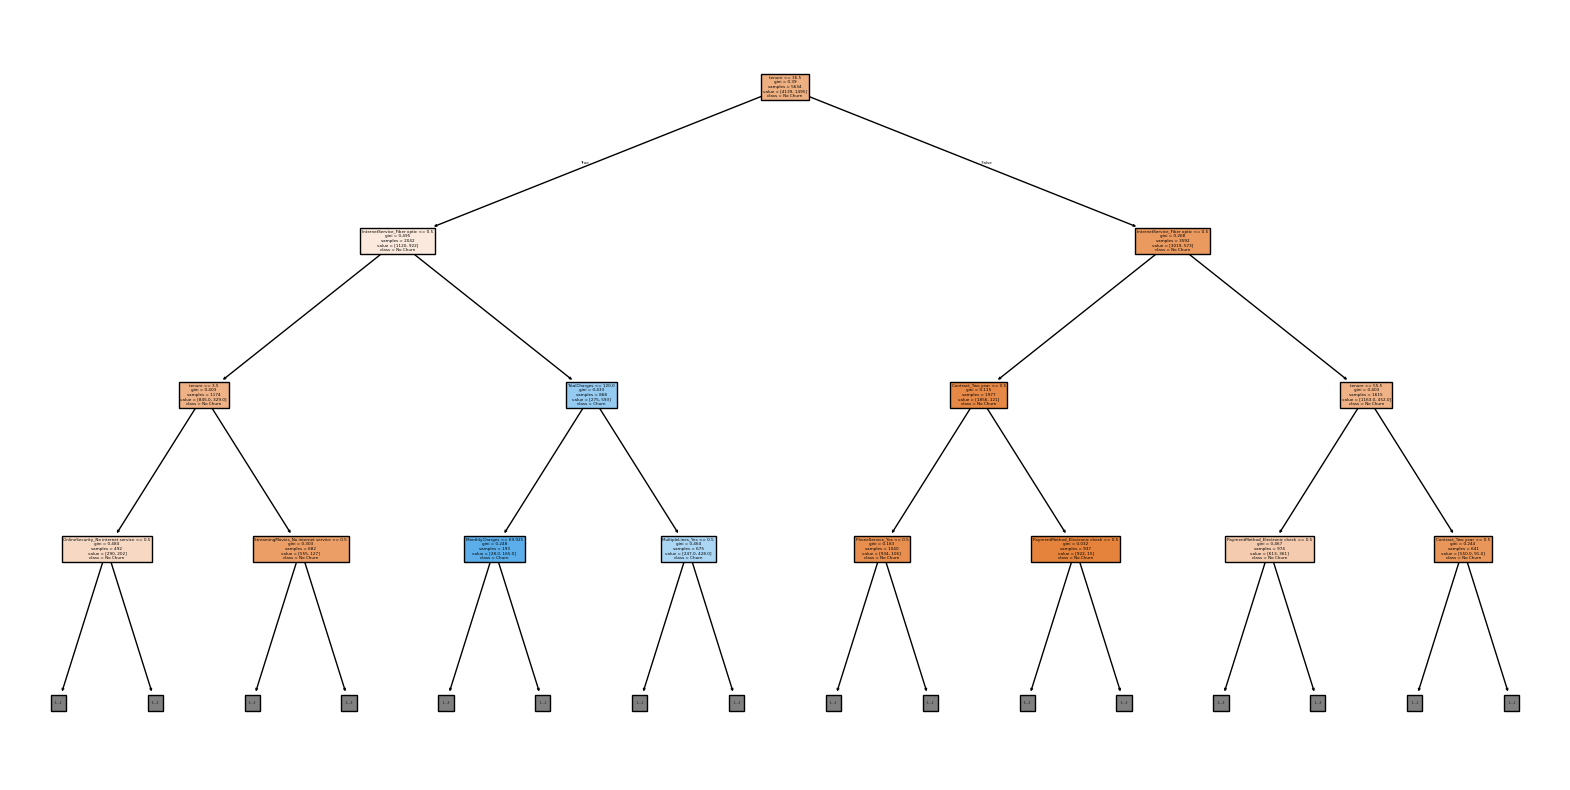

In [10]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_regularized,
    max_depth=3,
    feature_names=X.columns,
    class_names=['No Churn', 'Churn'],
    filled=True
)
plt.show();

### Feature Importance.

In [11]:
import pandas as pd

feature_importance = pd.Series(
    dt_regularized.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)

tenure                                 0.425425
InternetService_Fiber optic            0.360371
PaymentMethod_Electronic check         0.037052
TotalCharges                           0.036028
MonthlyCharges                         0.028070
MultipleLines_Yes                      0.023817
OnlineSecurity_No internet service     0.020832
Contract_Two year                      0.020714
StreamingMovies_No internet service    0.017516
Contract_One year                      0.008621
dtype: float64

### Feature importance in trees can be biased toward high-cardinality features.

### Creating a GridSearch Parameters

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 10, 20]
}

### Choosing the right Scoring Metric.

In [13]:
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

### Running the Grid Search

In [14]:
grid.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 5, ...], 'min_samples_split': [2, 10, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


### Inspect the Best Model.

In [15]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

### Evaluating the best model/parameters on the Test Data.

In [16]:
best_dt = grid.best_estimator_

print(classification_report(
    y_test,
    best_dt.predict(X_test)
))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1035
           1       0.54      0.52      0.53       374

    accuracy                           0.76      1409
   macro avg       0.68      0.68      0.68      1409
weighted avg       0.75      0.76      0.75      1409



In [17]:
feature_importance.head(10)

tenure                                 0.425425
InternetService_Fiber optic            0.360371
PaymentMethod_Electronic check         0.037052
TotalCharges                           0.036028
MonthlyCharges                         0.028070
MultipleLines_Yes                      0.023817
OnlineSecurity_No internet service     0.020832
Contract_Two year                      0.020714
StreamingMovies_No internet service    0.017516
Contract_One year                      0.008621
dtype: float64